In [12]:
%matplotlib inline

import os
import sys
sys.path.append('../')
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

import glob
import random
import cv2
import numpy as np
import networkx as nx
import torch
import torch.nn.functional as F
from datetime import datetime

import roma
import kornia
import utils.colmap as colmap_utils


from tqdm import tqdm
from copy import deepcopy
from PIL import Image
from matplotlib import pyplot as plt

from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images_ratio, load_and_preprocess_images_square
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

from utils.umeyama import umeyama
from utils.metric_torch import evaluate_auc, evaluate_pcd

torch._dynamo.config.accumulated_cache_size_limit = 512
device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

In [2]:
def run_VGGT(images, device, dtype):
    # images: [B, 3, H, W]

    # Run VGGT for camera and depth estimation
    model = VGGT()
    _URL = "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt"
    model.load_state_dict(torch.hub.load_state_dict_from_url(_URL))
    model.eval()
    model = model.to(device).to(dtype)
    print(f"Model loaded")

    with torch.no_grad():
        predictions = model(images.to(device, dtype), verbose=True)
        extrinsic, intrinsic = pose_encoding_to_extri_intri(predictions['pose_enc'], images.shape[-2:])
        extrinsic = extrinsic.squeeze(0).cpu().numpy()
        intrinsic = intrinsic.squeeze(0).cpu().numpy()
        depth_map = predictions['depth'].squeeze(0).cpu().numpy()
        depth_conf = predictions['depth_conf'].squeeze(0).cpu().numpy()
    
    return extrinsic, intrinsic, depth_map, depth_conf

In [3]:
# Get image paths and preprocess them
data_dir = "../data/free/free_dataset/hydrant"
sparse_dir_gt = os.path.join(data_dir, "sparse", "0")
dust_dir = os.path.join(data_dir, "mast3r")
images_dir = os.path.join(data_dir, "images")

cameras_gt = colmap_utils.read_cameras_binary(os.path.join(sparse_dir_gt, "cameras.bin"))
images_gt = colmap_utils.read_images_binary(os.path.join(sparse_dir_gt, "images.bin"))
pcd_gt = colmap_utils.read_points3D_binary(os.path.join(sparse_dir_gt, "points3D.bin"))
# images_gt = dict(sorted(images_gt.items(), key=lambda item: item[0]))

In [4]:
images_gt_keys = list(images_gt.keys())
random.seed(42)
random.shuffle(images_gt_keys)
images_gt_updated = {id: images_gt[id] for id in list(images_gt_keys)}
image_path_list = [os.path.join(images_dir, images_gt_updated[id].name) for id in images_gt_updated.keys()]
base_image_path_list = [os.path.basename(path) for path in image_path_list]
vggt_fixed_resolution = 518
images, original_coords = load_and_preprocess_images_ratio(image_path_list, vggt_fixed_resolution)

In [5]:
# Run VGGT to estimate camera and depth
# Run with 518x518 images
if not os.path.exists(f"./vggt_results_{data_dir.split('/')[-1]}.npz"):
    extrinsic, intrinsic, depth_map, depth_conf = run_VGGT(images, device, dtype)
    output_dict = {
        "extrinsic": extrinsic,
        "intrinsic": intrinsic,
        "depth_map": depth_map,
        "depth_conf": depth_conf,
        "base_image_path_list": base_image_path_list
    }
    np.savez(f"./vggt_results_{data_dir.split('/')[-1]}.npz", output_dict)
    torch.cuda.empty_cache()
else:
    output_dict = np.load(f"./vggt_results_{data_dir.split('/')[-1]}.npz", allow_pickle=True)['arr_0'].item()


inverse_idx = [images_gt_keys.index(key) for key in list(images_gt.keys())]
extrinsic = output_dict['extrinsic'][inverse_idx]
intrinsic = output_dict['intrinsic'][inverse_idx]
depth_map = output_dict['depth_map'][inverse_idx]
depth_conf = output_dict['depth_conf'][inverse_idx]
images = images[inverse_idx]
original_coords = original_coords[inverse_idx]
images_gt_keys = list(images_gt.keys())
images_gt_updated = {id: images_gt[id] for id in list(images_gt_keys)}
image_path_list = [os.path.join(images_dir, images_gt_updated[id].name) for id in images_gt_updated.keys()]
base_image_path_list = [os.path.basename(path) for path in image_path_list]
print("VGGT results loaded")

VGGT results loaded


In [6]:
fl_gt = torch.tensor([cameras_gt[image.camera_id].params[0:2] for image in images_gt_updated.values()], device=device)
translation_gt = torch.tensor([image.tvec for image in images_gt_updated.values()], device=device)
rotation_gt = torch.tensor([colmap_utils.qvec2rotmat(image.qvec) for image in images_gt_updated.values()], device=device)

# gt w2c
gt_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt_updated), 1, 1)
gt_se3[:, :3, :3] = rotation_gt
gt_se3[:, 3, :3] = translation_gt

# pred w2c
pred_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt_updated), 1, 1)
pred_se3[:, :3, :3] = torch.tensor(extrinsic[:, :3, :3], device=device)
pred_se3[:, 3, :3] = torch.tensor(extrinsic[:, :3, 3], device=device)

results = evaluate_auc(gt_se3, pred_se3, device)

    --  Umeyama Scale:  0.10716810800939235
    --  Umeyama Rotation: 
 [[ 0.84579078 -0.13225682  0.51686175]
 [ 0.14452347  0.98936105  0.01666428]
 [-0.51356685  0.06060417  0.85590667]]
    --  Umeyama Translation: 
 [[-0.00494413]
 [ 0.0340953 ]
 [-0.19855241]]


/tmp/ipykernel_7572/4132866928.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  fl_gt = torch.tensor([cameras_gt[image.camera_id].params[0:2] for image in images_gt_updated.values()], device=device)


    --  Pair Rot   Error (Deg) of Vanilla:       1.97
    --  Pair Trans Error (Deg) of Vanilla:      10.66
    --  AUC at 30: 0.6842


## 1. Calculate Tracking

In [8]:
import utils.opt as opt_utils

@torch.inference_mode()
def extract_matches(extrinsic, intrinsic, images, base_image_path_list, max_query_pts=4096, batch_size=256, pairing_angle_threshold=30):

    xfeat = torch.hub.load('/home/jing_li/.cache/torch/hub/verlab_accelerated_features_main', 
                           'XFeat', source='local', pretrained=True, top_k=max_query_pts)  # TODO: remove the local path

    pairs, pairs_cnt = opt_utils.image_pair_candidates(extrinsic, pairing_angle_threshold, unique_pairs=True)
    print("Total candidate image pairs found: ", pairs_cnt)

    indexes_i = list(range(len(base_image_path_list)-1))  # the last image 
    # indexes_j = [np.random.choice(pairs[idx_i], min(20, len(pairs[idx_i])), replace=False) for idx_i in indexes_i]
    indexes_j = [pairs[idx_i] for idx_i in indexes_i]
    indexes_i = [np.array([idx_i] * len(indexes_j[idx_i])) for idx_i in indexes_i]
    indexes_i = np.concatenate(indexes_i).tolist()
    indexes_j = np.concatenate(indexes_j).tolist()

    matches_list = []

    for i in tqdm(range(0, len(indexes_i), batch_size), desc="Matching image pairs..."):
        indexes_i_batch = indexes_i[i:i + batch_size]
        indexes_j_batch = indexes_j[i:i + batch_size]
        
        # Extract features for the batch
        images_i = images[indexes_i_batch]
        images_j = images[indexes_j_batch]
        
        # Match features
        matches_batch = xfeat.match_xfeat_star(images_i, images_j)
        matches_list.extend(matches_batch)

    num_matches = [len(m) for m in matches_list]

    indexes_i_expanded = []
    indexes_j_expanded = []

    for idx, n in enumerate(num_matches):
        indexes_i_expanded.append(np.array([indexes_i[idx]] * n, dtype=np.int64))
        indexes_j_expanded.append(np.array([indexes_j[idx]] * n, dtype=np.int64))
    indexes_i_expanded = np.concatenate(indexes_i_expanded)
    indexes_j_expanded = np.concatenate(indexes_j_expanded)

    image_names_i = np.array(base_image_path_list)[indexes_i_expanded]
    image_names_j = np.array(base_image_path_list)[indexes_j_expanded]

    corr_points_i = torch.cat([matches_list[k][:, :2] for k in range(len(matches_list))], dim=0).cpu()
    corr_points_j = torch.cat([matches_list[k][:, 2:] for k in range(len(matches_list))], dim=0).cpu()

    intrinsic_i = np.zeros((corr_points_i.shape[0], 4, 4), dtype=np.float32)
    intrinsic_j = np.zeros((corr_points_j.shape[0], 4, 4), dtype=np.float32)
    intrinsic_i[:, :3, :3] = intrinsic[indexes_i_expanded]
    intrinsic_j[:, :3, :3] = intrinsic[indexes_j_expanded]
    intrinsic_i[:, 3, 3] = 1.0
    intrinsic_j[:, 3, 3] = 1.0

    extrinsic_i = np.zeros((corr_points_i.shape[0], 4, 4), dtype=np.float32)
    extrinsic_j = np.zeros((corr_points_j.shape[0], 4, 4), dtype=np.float32)
    extrinsic_i[:, :3, :4] = extrinsic[indexes_i_expanded]
    extrinsic_j[:, :3, :4] = extrinsic[indexes_j_expanded]
    extrinsic_i[:, 3, 3] = 1.0
    extrinsic_j[:, 3, 3] = 1.0

    device = corr_points_i.device

    intrinsic_i_tensor = torch.FloatTensor(intrinsic_i).to(device)
    intrinsic_j_tensor = torch.FloatTensor(intrinsic_j).to(device)
    extrinsic_i_tensor = torch.FloatTensor(extrinsic_i).to(device)
    extrinsic_j_tensor = torch.FloatTensor(extrinsic_j).to(device)

    P_i = intrinsic_i_tensor @ extrinsic_i_tensor
    P_j = intrinsic_j_tensor @ extrinsic_j_tensor
    Fm = kornia.geometry.epipolar.fundamental_from_projections(P_i[:, :3], P_j[:, :3])
    err = kornia.geometry.symmetrical_epipolar_distance(corr_points_i[:, None, :2], corr_points_j[:, None, :2], Fm, squared=False, eps=1e-08)
    
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.figure(figsize=(10, 5))
    plt.hist(err.cpu().numpy(), bins=100, density=True, range=(0, 20))
    plt.title(f"Symmetrical Epipolar Distance Distribution of {len(err)} correspondences, average: {err.mean().item():.3f}, std: {err.std().item():.3f}")
    plt.xlabel("Distance")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

    hist, bin_edges = torch.histogram(err.cpu(), bins=100, range=(0, 20), density=True)  # move to cpu to avoid CUDA "backend"
    corr_weights = torch.zeros_like(err)
    for i in range(len(bin_edges) - 1):
        mask = (err >= bin_edges[i]) & (err < bin_edges[i + 1])
        if torch.any(mask):
            corr_weights[mask] = (hist[i] * (bin_edges[i + 1] - bin_edges[i])) / (bin_edges[-1] - bin_edges[0])
    corr_weights /= corr_weights.mean()
    
    # set corr_weights to 0 for points outside the image frame
    in_frame_i = (corr_points_i[..., 0] > images.shape[-1]) & (corr_points_i[..., 0] < 0) & \
                    (corr_points_i[..., 1] > images.shape[-2]) & (corr_points_i[..., 1] < 0)
    in_frame_j = (corr_points_j[..., 0] > images.shape[-1]) & (corr_points_j[..., 0] < 0) & \
                    (corr_points_j[..., 1] > images.shape[-2]) & (corr_points_j[..., 1] < 0)
    corr_weights[in_frame_i & in_frame_j] = 0.0
    
    # rearrange corr_points_i_normalized and corr_points_j_normalized to (P, N, 2)
    P, N = len(num_matches), max(num_matches)
    corr_points_i_batched = torch.zeros((P, N, 2), dtype=corr_points_i.dtype, device=corr_points_i.device)
    corr_points_j_batched = torch.zeros((P, N, 2), dtype=corr_points_j.dtype, device=corr_points_j.device)
    corr_weights_batched = torch.zeros((P, N, 1), dtype=corr_weights.dtype, device=corr_weights.device)
    image_names_i_batched = np.zeros((P), dtype=image_names_i.dtype)
    image_names_j_batched = np.zeros((P), dtype=image_names_j.dtype)

    start_idx = 0
    for p in range(P):
        end_idx = start_idx + num_matches[p]
        corr_points_i_batched[p, :num_matches[p]] = corr_points_i[start_idx:end_idx]
        corr_points_j_batched[p, :num_matches[p]] = corr_points_j[start_idx:end_idx]
        corr_weights_batched[p, :num_matches[p]] = corr_weights[start_idx:end_idx]
        image_names_i_batched[p] = image_names_i[start_idx]
        image_names_j_batched[p] = image_names_j[start_idx]
        assert (image_names_i[start_idx:end_idx] == image_names_i_batched[p]).all()
        assert (image_names_j[start_idx:end_idx] == image_names_j_batched[p]).all()
        start_idx = end_idx
    
    output_dict = {
        "corr_points_i": corr_points_i_batched,
        "corr_points_j": corr_points_j_batched,
        "corr_weights": corr_weights_batched,
        "image_names_i": image_names_i_batched,
        "image_names_j": image_names_j_batched,
        "num_matches": num_matches,
        "epipolar_err": err.median().item()
    }

    return output_dict

In [11]:
from vggt.dependency.track_predict import generate_rank_by_dino

batch_size = 256
max_query_pts = 4096
xfeat = torch.hub.load('/home/jing_li/.cache/torch/hub/verlab_accelerated_features_main', 
                           'XFeat', source='local', pretrained=True, top_k=max_query_pts)  # TODO: remove the local path

pairs, pairs_cnt = opt_utils.image_pair_candidates(extrinsic, 30, unique_pairs=True)
query_frame_indexes = generate_rank_by_dino(images, query_frame_num=max_query_pts, device=device)

print("Total candidate image pairs found: ", pairs_cnt)

Using cache found in /home/jing_li/.cache/torch/hub/facebookresearch_dinov2_main


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

Total candidate image pairs found:  2948


Matching image pairs...: 100%|██████████| 12/12 [09:21<00:00, 46.82s/it]  


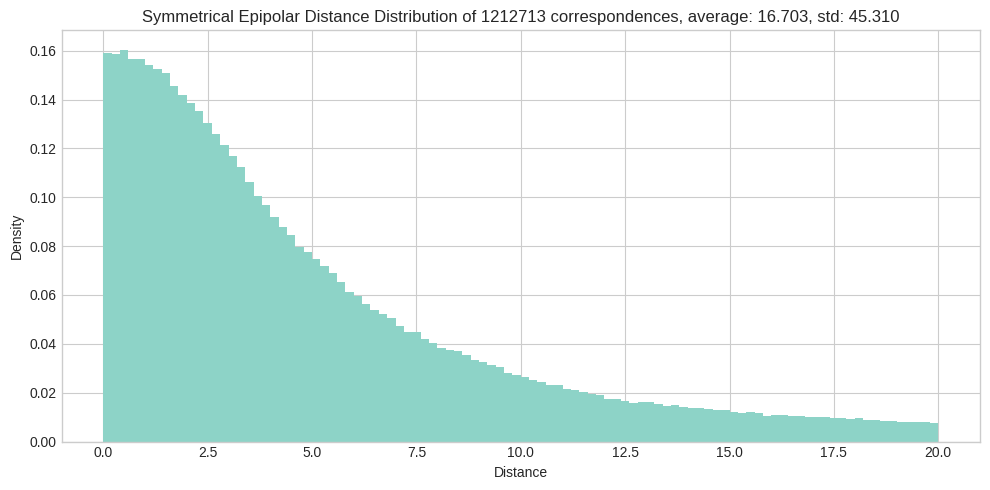

Saved matches to ./matches_hydrant.pt


In [11]:
target_path = os.path.join("./", f"matches_{data_dir.split('/')[-1]}.pt")
if os.path.exists(target_path):
    print(f"Found existing matches at {target_path}, loading it")
    match_outputs = torch.load(target_path)
else:
    match_outputs = extract_matches(extrinsic, intrinsic, images, base_image_path_list, 2048, pairing_angle_threshold=30)
    match_outputs["original_width"] = images.shape[-1]
    match_outputs["original_height"] = images.shape[-2]
   
    torch.save(match_outputs, target_path)
    print(f"Saved matches to {target_path}")

## 2. BA

In [9]:
import pycolmap
import copy
from vggt.dependency.projection import project_3D_points_np
from vggt.dependency.np_to_pycolmap import _build_pycolmap_intri

def rename_colmap_recons_and_rescale_camera(
    reconstruction, image_paths, original_coords, img_size, shift_point2d_to_original_res=False, shared_camera=False
):
    rescale_camera = True

    for pyimageid in reconstruction.images:
        # Reshaped the padded&resized image to the original size
        # Rename the images to the original names
        pyimage = reconstruction.images[pyimageid]
        pycamera = reconstruction.cameras[pyimage.camera_id]
        pyimage.name = image_paths[pyimageid - 1]

        if rescale_camera:
            # Rescale the camera parameters
            pred_params = copy.deepcopy(pycamera.params)

            real_image_size = original_coords[pyimageid - 1, -2:]
            resize_ratio = max(real_image_size) / img_size
            pred_params = pred_params * resize_ratio
            real_pp = real_image_size / 2
            pred_params[-2:] = real_pp  # center of the image

            pycamera.params = pred_params
            pycamera.width = real_image_size[0]
            pycamera.height = real_image_size[1]

        if shift_point2d_to_original_res:
            # Also shift the point2D to original resolution
            top_left = original_coords[pyimageid - 1, :2]

            for point2D in pyimage.points2D:
                point2D.xy = (point2D.xy - top_left) * resize_ratio

        if shared_camera:
            # If shared_camera, all images share the same camera
            # no need to rescale any more
            rescale_camera = False

    return reconstruction

def batch_np_matrix_to_pycolmap_xfeat(
    points3d,
    extrinsics,
    intrinsics,
    tracks,
    image_size,
    masks=None,
    max_reproj_error=None,
    max_points3D_val=3000,
    shared_camera=False,
    camera_type="SIMPLE_PINHOLE",
    extra_params=None,
    min_inlier_per_frame=64,
    points_rgb=None,
):
    """
    Convert Batched NumPy Arrays to PyCOLMAP

    Check https://github.com/colmap/pycolmap for more details about its format

    NOTE that colmap expects images/cameras/points3D to be 1-indexed
    so there is a +1 offset between colmap index and batch index


    NOTE: different from VGGSfM, this function:
    1. Use np instead of torch
    2. Frame index and camera id starts from 1 rather than 0 (to fit the format of PyCOLMAP)
    """
    # points3d: Px3
    # extrinsics: Nx3x4
    # intrinsics: Nx3x3
    # tracks: NxPx2
    # masks: NxP
    # image_size: 2, assume all the frames have been padded to the same size
    # where N is the number of frames and P is the number of tracks

    N, P, _ = tracks.shape
    assert len(extrinsics) == N
    assert len(intrinsics) == N
    assert len(points3d) == P
    assert image_size.shape[0] == 2

    reproj_mask = None

    if max_reproj_error is not None:
        projected_points_2d, projected_points_cam = project_3D_points_np(points3d, extrinsics, intrinsics)
        projected_diff = np.linalg.norm(projected_points_2d - tracks, axis=-1)
        projected_points_2d[projected_points_cam[:, -1] <= 0] = 1e6
        reproj_mask = projected_diff < max_reproj_error

    if masks is not None and reproj_mask is not None:
        masks = np.logical_and(masks, reproj_mask)
    elif masks is not None:
        masks = masks
    else:
        masks = reproj_mask

    assert masks is not None

    if masks.sum(1).min() < min_inlier_per_frame:
        print(f"Not enough inliers per frame, skip BA.")
        return None, None

    # Reconstruction object, following the format of PyCOLMAP/COLMAP
    reconstruction = pycolmap.Reconstruction()

    inlier_num = masks.sum(0)
    valid_mask = inlier_num >= 2  # a track is invalid if without two inliers
    valid_idx = np.nonzero(valid_mask)[0]

    # Only add 3D points that have sufficient 2D points
    for vidx in valid_idx:
        # Use RGB colors if provided, otherwise use zeros
        rgb = points_rgb[vidx] if points_rgb is not None else np.zeros(3)
        reconstruction.add_point3D(points3d[vidx], pycolmap.Track(), rgb)

    num_points3D = len(valid_idx)
    camera = None
    # frame idx
    for fidx in range(N):
        # set camera
        if camera is None or (not shared_camera):
            pycolmap_intri = _build_pycolmap_intri(fidx, intrinsics, camera_type, extra_params)

            camera = pycolmap.Camera(
                model=camera_type, width=image_size[0], height=image_size[1], params=pycolmap_intri, camera_id=fidx + 1
            )

            # add camera
            reconstruction.add_camera(camera)

        # set image
        cam_from_world = pycolmap.Rigid3d(
            pycolmap.Rotation3d(extrinsics[fidx][:3, :3]), extrinsics[fidx][:3, 3]
        )  # Rot and Trans

        image = pycolmap.Image(
            id=fidx + 1, name=f"image_{fidx + 1}", camera_id=camera.camera_id, cam_from_world=cam_from_world
        )

        points2D_list = []

        point2D_idx = 0

        # NOTE point3D_id start by 1
        for point3D_id in range(1, num_points3D + 1):
            original_track_idx = valid_idx[point3D_id - 1]

            if (reconstruction.points3D[point3D_id].xyz < max_points3D_val).all():
                if masks[fidx][original_track_idx]:
                    # It seems we don't need +0.5 for BA
                    point2D_xy = tracks[fidx][original_track_idx]
                    # Please note when adding the Point2D object
                    # It not only requires the 2D xy location, but also the id to 3D point
                    points2D_list.append(pycolmap.Point2D(point2D_xy, point3D_id))

                    # add element
                    track = reconstruction.points3D[point3D_id].track
                    track.add_element(fidx + 1, point2D_idx)
                    point2D_idx += 1

        assert point2D_idx == len(points2D_list)

        try:
            image.points2D = pycolmap.ListPoint2D(points2D_list)
            image.registered = True
        except:
            print(f"frame {fidx + 1} is out of BA")
            image.registered = False

        # add image
        reconstruction.add_image(image)

    return reconstruction, valid_mask


In [10]:
import trimesh

with torch.no_grad():
    # make K, w2cam, cam2w
    points_3d = torch.tensor(unproject_depth_map_to_point_map(depth_map, extrinsic, intrinsic), dtype=images.dtype)  # (N, H, W, 3)
    imsizes = torch.tensor([images.shape[-1], images.shape[-2]]).float()
    corr_points_i = match_outputs["corr_points_i"].clone()
    corr_points_j = match_outputs["corr_points_j"].clone()
    corr_weights = match_outputs["corr_weights"].clone()
    num_matches = match_outputs["num_matches"]
    indexes_i = [base_image_path_list.index(img_name) for img_name in match_outputs["image_names_i"]]
    indexes_j = [base_image_path_list.index(img_name) for img_name in match_outputs["image_names_j"]]

    depth_map_tensor = torch.tensor(depth_map)  # [B, H, W]
    
    corr_points_i_normalized = corr_points_i / imsizes[None, None, :] * 2 - 1
    corr_points_j_normalized = corr_points_j / imsizes[None, None, :] * 2 - 1

    depths_i_list, depths_j_list, batch_size = [], [], 16
    rgbs_i_list, rgbs_j_list = [], []
    points_i_list, points_j_list = [], []
    for start_idx in range(0, len(corr_points_i_normalized), batch_size):
        end_idx = min(start_idx + batch_size, len(corr_points_i_normalized))
        depths_i_list.append(F.grid_sample(
            depth_map_tensor[indexes_i[start_idx:end_idx]].permute(0, 3, 1, 2),
            corr_points_i_normalized[start_idx:end_idx, None],
            align_corners=True,
            mode='bilinear'
        ).squeeze(1, 2))

        depths_j_list.append(F.grid_sample(
            depth_map_tensor[indexes_j[start_idx:end_idx]].permute(0, 3, 1, 2),
            corr_points_j_normalized[start_idx:end_idx, None],
            align_corners=True,
            mode='bilinear'
        ).squeeze(1, 2))

        rgbs_i_list.append(F.grid_sample(
            images[indexes_i[start_idx:end_idx]],
            corr_points_i_normalized[start_idx:end_idx, None],
            align_corners=True,
            mode='bilinear'
        ).squeeze(2).permute(0, 2, 1))

        rgbs_j_list.append(F.grid_sample(
            images[indexes_j[start_idx:end_idx]],
            corr_points_j_normalized[start_idx:end_idx, None],
            align_corners=True,
            mode='bilinear'
        ).squeeze(2).permute(0, 2, 1))

        points_i_list.append(F.grid_sample(
            points_3d[indexes_i[start_idx:end_idx]].permute(0, 3, 1, 2),
            corr_points_i_normalized[start_idx:end_idx, None],
            align_corners=True,
            mode='bilinear'
        ).squeeze(2).permute(0, 2, 1))

        points_j_list.append(F.grid_sample(
            points_3d[indexes_j[start_idx:end_idx]].permute(0, 3, 1, 2),
            corr_points_j_normalized[start_idx:end_idx, None],
            align_corners=True,
            mode='bilinear'
        ).squeeze(2).permute(0, 2, 1))

    
    depths_i = torch.cat(depths_i_list, dim=0).squeeze(-1)
    depths_j = torch.cat(depths_j_list, dim=0).squeeze(-1)

    rgbs_i = torch.cat(rgbs_i_list, dim=0)
    rgbs_j = torch.cat(rgbs_j_list, dim=0)

    points_i = torch.cat(points_i_list, dim=0)
    points_j = torch.cat(points_j_list, dim=0)
    
    cam2w = torch.zeros_like(torch.tensor(extrinsic))  # (N, 3, 4)
    cam2w[:, :3, :3] = torch.tensor(extrinsic[:, :3, :3]).permute(0, 2, 1)
    cam2w[:, :, 3:] = -cam2w[:, :3, :3] @ torch.tensor(extrinsic[:, :, 3:])

    Ks_i = torch.tensor(intrinsic[indexes_i])
    Ks_j = torch.tensor(intrinsic[indexes_j])
    cam2w_i = cam2w[indexes_i]  # (N, 3, 4)
    cam2w_j = cam2w[indexes_j]  # (N, 3, 4)
    
    cam_coords_i = torch.stack([
        (corr_points_i[..., 0] - Ks_i[:, None, 0, 2]) / Ks_i[:, None, 0, 0] * depths_i,
        (corr_points_i[..., 1] - Ks_i[:, None, 1, 2]) / Ks_i[:, None, 1, 1] * depths_i,
        depths_i
    ], dim=-1)  # (N, P, 3)
    cam_coords_j = torch.stack([
        (corr_points_j[..., 0] - Ks_j[:, None, 0, 2]) / Ks_j[:, None, 0, 0] * depths_j,
        (corr_points_j[..., 1] - Ks_j[:, None, 1, 2]) / Ks_j[:, None, 1, 1] * depths_j,
        depths_j
    ], dim=-1)   # (N, P, 3)
    world_coords_i = cam_coords_i @ cam2w_i[:, :3, :3].permute(0, 2, 1) + cam2w_i[:, None, :, 3]
    world_coords_j = cam_coords_j @ cam2w_j[:, :3, :3].permute(0, 2, 1) + cam2w_j[:, None, :, 3]

    corr_weights_mask = (corr_weights.squeeze(-1) > 0.1) & (depths_i.squeeze() > 0) & (depths_j.squeeze() > 0) & \
                        (corr_points_i_normalized[..., 0] >= -1.0) & (corr_points_i_normalized[..., 0] <= 1.0) & \
                        (corr_points_i_normalized[..., 1] >= -1.0) & (corr_points_i_normalized[..., 1] <= 1.0) & \
                        (corr_points_j_normalized[..., 0] >= -1.0) & (corr_points_j_normalized[..., 0] <= 1.0) & \
                        (corr_points_j_normalized[..., 1] >= -1.0) & (corr_points_j_normalized[..., 1] <= 1.0)
    
    rgbs_i = (rgbs_i.cpu().numpy() * 255).astype(np.uint8)
    rgbs_j = (rgbs_j.cpu().numpy() * 255).astype(np.uint8)
    world_coords_i = world_coords_i.cpu().numpy().astype(np.float64)
    world_coords_j = world_coords_j.cpu().numpy().astype(np.float64)
    corr_points_i = corr_points_i.cpu().numpy()
    corr_points_j = corr_points_j.cpu().numpy()

    # Validation
    # rgbs_i = rgbs_i[corr_weights_mask]
    # rgbs_j = rgbs_j[corr_weights_mask]
    # world_coords_i = world_coords_i[corr_weights_mask]
    # world_coords_j = world_coords_j[corr_weights_mask]
    # points_i = points_i[corr_weights_mask]
    # points_j = points_j[corr_weights_mask]
    
    # rgbs_i = np.concatenate([rgbs_i, np.ones((rgbs_i.shape[0], 1), dtype=np.uint8) * 255], axis=-1)
    # rgbs_j = np.concatenate([rgbs_j, np.ones((rgbs_j.shape[0], 1), dtype=np.uint8) * 255], axis=-1)

    # trimesh.PointCloud(world_coords_i, colors=rgbs_i).export("./pcd_i.ply")
    # trimesh.PointCloud(world_coords_j, colors=rgbs_j).export("./pcd_j.ply")

In [15]:
# reconstruction, valid_track_mask = batch_np_matrix_to_pycolmap_xfeat(
#     points_3d,
#     extrinsic[inverse_idx],
#     intrinsic[inverse_idx],
#     pred_tracks,
#     image_size,
#     masks=track_mask,
#     max_reproj_error=8,
#     shared_camera=True,
#     camera_type="SIMPLE_PINHOLE",
#     points_rgb=points_rgb,
# )

max_reproj_error = 8
shared_camera = True
camera_type = "PINHOLE"
extra_params = None
intrinsics = intrinsic
extrinsics = extrinsic
masks = corr_weights_mask
image_size = np.array([images.shape[-1], images.shape[-2]])

M, P = masks.shape
N = len(intrinsics)
assert len(extrinsics) == N
assert len(indexes_i) == M
assert len(indexes_j) == M
assert masks is not None

# Reconstruction object, following the format of PyCOLMAP/COLMAP
reconstruction = pycolmap.Reconstruction()

# Only add 3D points that have sufficient 2D points
points_2D_dict = {}

# for vidx in valid_idx:
#     # Use RGB colors if provided, otherwise use zeros
#     rgb = points_rgb[vidx] if points_rgb is not None else np.zeros(3)
#     reconstruction.add_point3D(points3d[vidx], pycolmap.Track(), rgb)

for m in range(M):
    rgb_i = rgbs_i[m][masks[m]]
    rgb_j = rgbs_j[m][masks[m]]
    world_xyz_i = world_coords_i[m][masks[m]]
    world_xyz_j = world_coords_j[m][masks[m]]
    corr_point_i = corr_points_i[m][masks[m]]
    corr_point_j = corr_points_j[m][masks[m]]

    for idx in range(len(rgb_i)):
        world_xyz = (world_xyz_i[idx]+world_xyz_j[idx])/2
        point3D_id = reconstruction.add_point3D(world_xyz, pycolmap.Track(), rgb_i[idx])
        index_i = indexes_i[m]
        index_j = indexes_j[m]

        if index_i not in points_2D_dict:
            points_2D_dict[index_i] = []
        if index_j not in points_2D_dict:
            points_2D_dict[index_j] = []
        points_2D_dict[index_i].append(pycolmap.Point2D(corr_point_i[idx], point3D_id))
        points_2D_dict[index_j].append(pycolmap.Point2D(corr_point_j[idx], point3D_id))

        track = reconstruction.points3D[point3D_id].track
        track.add_element(index_i + 1, len(points_2D_dict[index_i])-1)
        track.add_element(index_j + 1, len(points_2D_dict[index_j])-1)
    
camera = None
# frame idx
for fidx in range(N):
    # set camera
    if camera is None or (not shared_camera):
        pycolmap_intri = _build_pycolmap_intri(fidx, intrinsics, camera_type, extra_params)

        camera = pycolmap.Camera(
            model=camera_type, width=image_size[0], height=image_size[1], params=pycolmap_intri, camera_id=fidx + 1
        )

        # add camera
        reconstruction.add_camera(camera)

    # set image
    cam_from_world = pycolmap.Rigid3d(
        pycolmap.Rotation3d(extrinsics[fidx][:3, :3]), extrinsics[fidx][:3, 3]
    )  # Rot and Trans

    image = pycolmap.Image(
        id=fidx + 1, name=f"image_{fidx + 1}", camera_id=camera.camera_id, cam_from_world=cam_from_world
    )

    try:
        image.points2D = pycolmap.ListPoint2D(points_2D_dict[fidx])
        image.registered = True
    except:
        print(f"frame {fidx + 1} is out of BA")
        image.registered = False

    # add image
    reconstruction.add_image(image)

print("Total points3D added: ", len(reconstruction.points3D))
print("Total images added: ", len(reconstruction.images))

# Run bundle adjustment
print("Start bundle adjustment...")
ba_options = pycolmap.BundleAdjustmentOptions()
pycolmap.bundle_adjustment(reconstruction, ba_options)

Total points3D added:  1028397
Total images added:  152
Start bundle adjustment...


I20250906 11:07:54.486351 49816 misc.cc:198] 
Global bundle adjustment
I20250906 11:15:19.884331 49816 misc.cc:205] 
Bundle adjustment report
------------------------
I20250906 11:15:19.884440 49816 bundle_adjustment.cc:942] 
    Residuals : 4113588
   Parameters : 3086098
   Iterations : 101
         Time : 442.016 [s]
 Initial cost : 11.7961 [px]
   Final cost : 2.37967 [px]
  Termination : No convergence

I20250906 11:15:19.884450 49816 timer.cc:91] Elapsed time: 7.423 [minutes]


In [16]:
reconstruction = colmap_utils.rename_colmap_recons_and_rescale_camera(
    reconstruction,
    base_image_path_list,
    original_coords.cpu().numpy(),
    img_size=(imsizes[0], imsizes[1]),
    shift_point2d_to_original_res=True,
    shared_camera=shared_camera,
)

print(f"Saving reconstruction to ./sparse/0")
sparse_reconstruction_dir = os.path.join("./sparse/0")
os.makedirs(sparse_reconstruction_dir, exist_ok=True)
reconstruction.write(sparse_reconstruction_dir)

Saving reconstruction to ./sparse/0


In [17]:
cameras_ba = colmap_utils.read_cameras_binary(os.path.join("./sparse/0", "cameras.bin"))
images_ba = colmap_utils.read_images_binary(os.path.join("./sparse/0", "images.bin"))

images_ba_updated = {id: images_ba[id] for id in list(images_gt_keys)}
translation_ba = torch.tensor([image.tvec for image in images_ba_updated.values()], device=device)
rotation_ba = torch.tensor([colmap_utils.qvec2rotmat(image.qvec) for image in images_ba_updated.values()], device=device)

# pred w2c
ba_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_ba_updated), 1, 1)
ba_se3[:, :3, :3] = rotation_ba
ba_se3[:, 3, :3] = translation_ba

results = evaluate_auc(gt_se3, ba_se3, device)

    --  Umeyama Scale:  0.13922844999466655
    --  Umeyama Rotation: 
 [[ 0.83793526 -0.13362013  0.52915988]
 [ 0.14918797  0.98871772  0.01342266]
 [-0.52498332  0.06769696  0.84841599]]
    --  Umeyama Translation: 
 [[-0.1057633 ]
 [ 0.01605802]
 [-0.20710195]]
    --  Pair Rot   Error (Deg) of Vanilla:      10.51
    --  Pair Trans Error (Deg) of Vanilla:      23.12
    --  AUC at 30: 0.3119
